# Fake News Detection and Automated Fact-Checking on the LIAR Dataset

In an era of rapidly spreading misinformation, automated fact‐checking has become a critical tool for evaluating the veracity of public statements. This project leverages the LIAR dataset, a widely recognized benchmark for fake news detection, to build models that classify political statements into veracity categories. We explore a range of natural language processing (NLP) machine learning approaches. We hypothesize that integrating contextual metadata with textual features enhances the accuracy of automated fake news detection, outperforming models relying solely on textual information. Our experiments reveal that baseline classifiers such as Logistic Regression can perform relatively well and are improved when more advanced machine learning methods such as Random Forests are implemented. Overall, our findings underscore the trade-offs between model complexity, training data volume, and computational constraints in the quest for accurate automated fact-checking.

In [20]:
import pandas as pd
import numpy as np
import re
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.impute import SimpleImputer

### Importing Libraries
We import necessary Python libraries:
- `pandas`, `numpy`: For data manipulation
- `re`: For regex-based text cleaning
- `gensim`: To build Word2Vec embeddings
- `sklearn`: For machine learning models and preprocessing
- `matplotlib`, `seaborn`: For visualizations
- `wordcloud`: To generate word cloud visualizations

## Load and Preprocess Data

In [3]:

# Load dataset
train_df = pd.read_csv("liar_dataset/train.tsv", delimiter="\t", header=None)
test_df = pd.read_csv("liar_dataset/test.tsv", delimiter="\t", header=None)

# Define column names
column_names = [
    "ID", "Label", "Statement", "Subject", "Speaker", "Speaker_Job",
    "State", "Party", "Barely_True_Count", "False_Count", "Half_True_Count",
    "Mostly_True_Count", "Pants_On_Fire_Count", "Context"
]
train_df.columns = column_names
test_df.columns = column_names

# Handle NaNs
numeric_features = ["Barely_True_Count", "False_Count", "Half_True_Count", "Mostly_True_Count", "Pants_On_Fire_Count"]
train_df = train_df.dropna(subset=numeric_features)
test_df = test_df.dropna(subset=numeric_features)

categorical_features = ["Speaker", "Speaker_Job", "State", "Party", "Subject", "Context"]
train_df[categorical_features] = train_df[categorical_features].fillna("Unknown")
test_df[categorical_features] = test_df[categorical_features].fillna("Unknown")

## Feature Engineering

In [4]:
# Preprocessing function for statements
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation
    return text

train_df["Processed_Statement"] = train_df["Statement"].apply(preprocess_text)
test_df["Processed_Statement"] = test_df["Statement"].apply(preprocess_text)

# Simplify labels
label_mapping = {
    "true": "true", "mostly-true": "true",
    "half-true": "somewhat-true", "barely-true": "somewhat-true",
    "false": "false", "pants-fire": "false"
}
train_df["Simplified_Label"] = train_df["Label"].map(label_mapping)
test_df["Simplified_Label"] = test_df["Label"].map(label_mapping)

### Text Cleaning
We clean the statement text by removing special characters and lowercasing all letters. This normalizes text and improves model generalization.

## Exploratory Data Analysis (EDA)

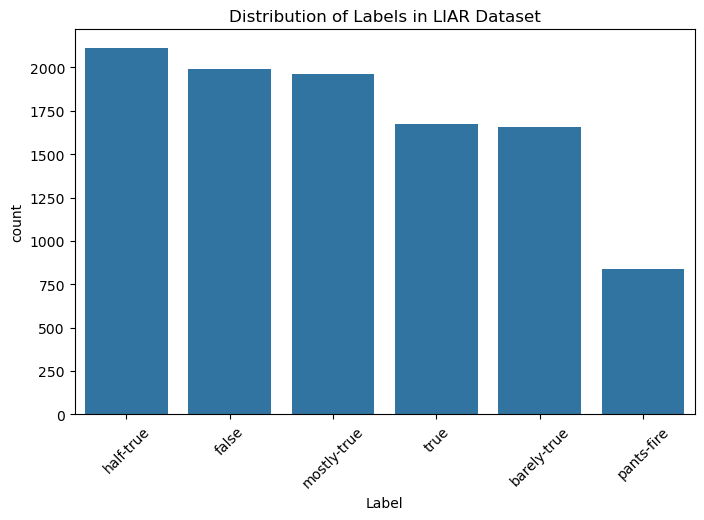

In [5]:
# Plot label distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x="Label", order=train_df["Label"].value_counts().index)
plt.title("Distribution of Labels in LIAR Dataset")
plt.xticks(rotation=45)
plt.show()

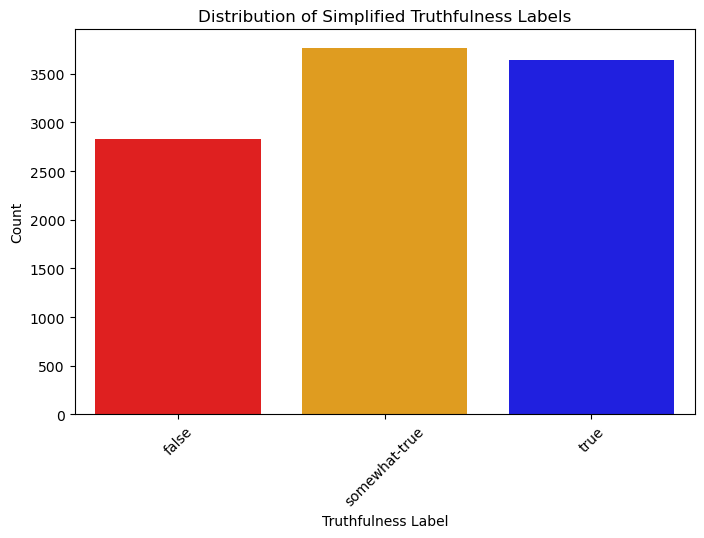

In [6]:
# Statement length column
train_df["Statement_Length"] = train_df["Statement"].apply(lambda x: len(str(x).split()))

# Color mapping for truthfulness
truthfulness_colors = {"false": "red", "somewhat-true": "orange", "true": "blue"}

# Label Distribution Analysis
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x="Simplified_Label", order=["false", "somewhat-true", "true"], palette=truthfulness_colors)
plt.title("Distribution of Simplified Truthfulness Labels")
plt.xlabel("Truthfulness Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

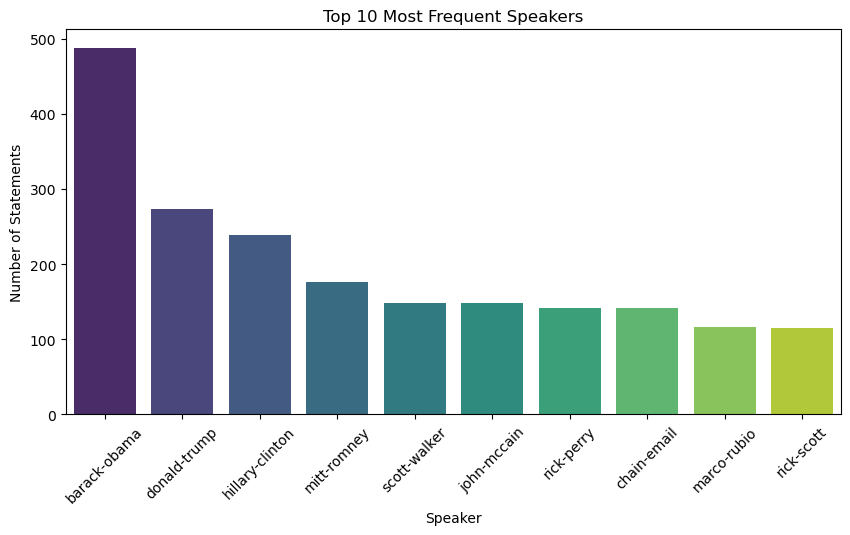

In [7]:
# Speaker Analysis: Most Frequent Speakers
top_speakers = train_df["Speaker"].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_speakers.index, y=top_speakers.values, palette="viridis")
plt.title("Top 10 Most Frequent Speakers")
plt.xlabel("Speaker")
plt.ylabel("Number of Statements")
plt.xticks(rotation=45)
plt.show()

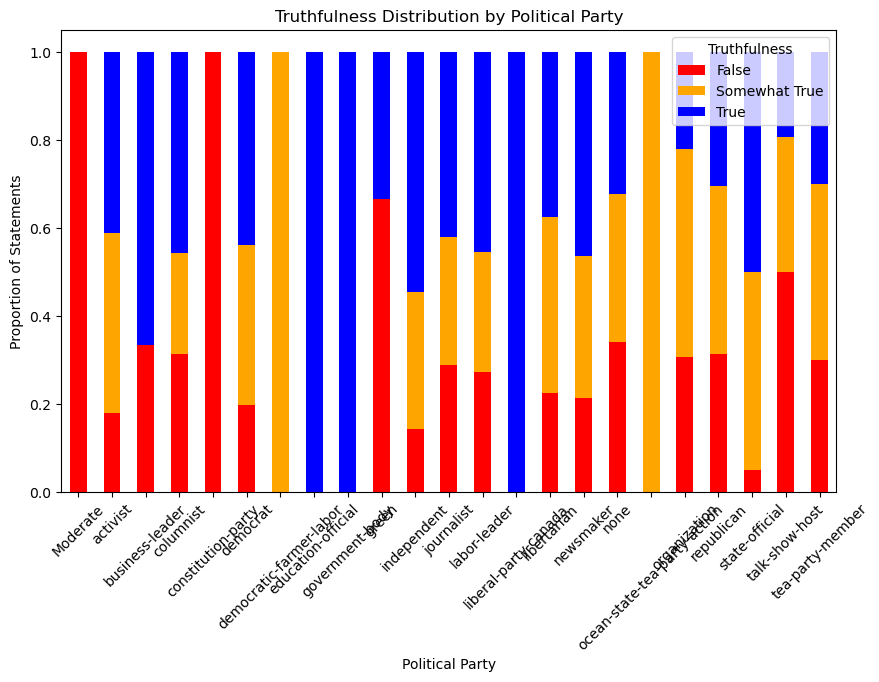

In [8]:
# Party Affiliation vs. Truthfulness
party_truth_table = pd.crosstab(train_df["Party"], train_df["Simplified_Label"], normalize="index")
party_truth_table.plot(kind="bar", stacked=True, figsize=(10, 6), color=[truthfulness_colors[label] for label in party_truth_table.columns])
plt.title("Truthfulness Distribution by Political Party")
plt.xlabel("Political Party")
plt.ylabel("Proportion of Statements")
plt.legend(title="Truthfulness", labels=["False", "Somewhat True", "True"])
plt.xticks(rotation=45)
plt.show()

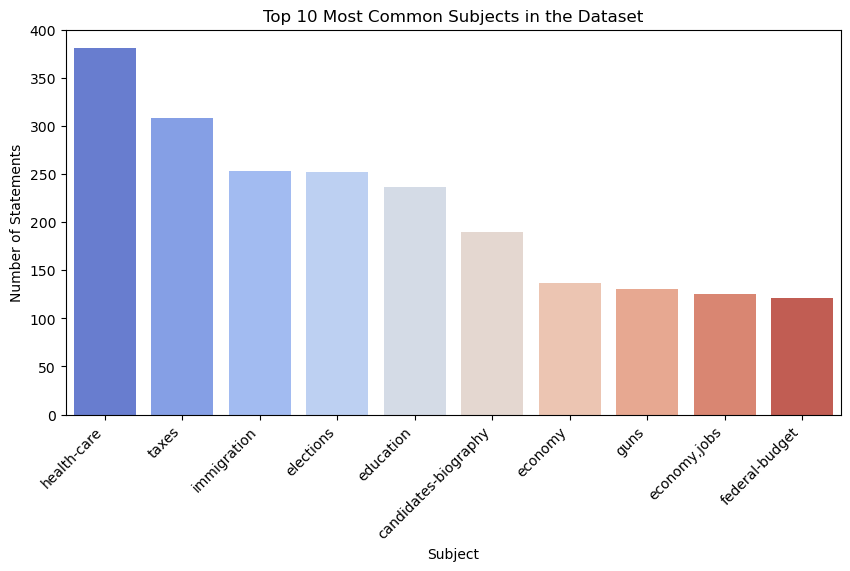

In [9]:
# Subject Analysis
top_subjects = train_df["Subject"].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_subjects.index, y=top_subjects.values, palette="coolwarm")
plt.title("Top 10 Most Common Subjects in the Dataset")
plt.xlabel("Subject")
plt.ylabel("Number of Statements")
plt.xticks(rotation=45, ha="right")
plt.show()

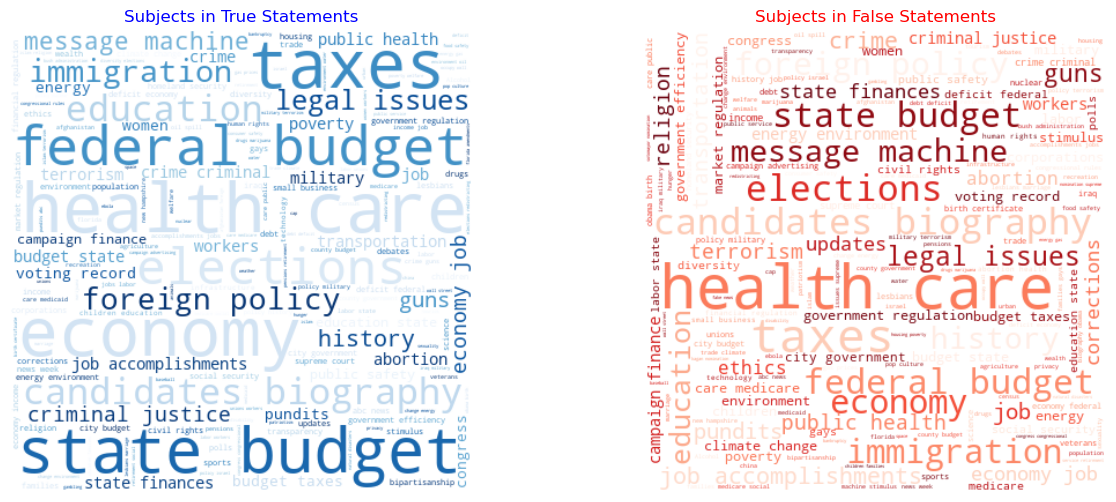

In [10]:
# Word Clouds
true_subjects = " ".join(train_df[train_df["Simplified_Label"] == "true"]["Subject"].dropna())
false_subjects = " ".join(train_df[train_df["Simplified_Label"] == "false"]["Subject"].dropna())

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
wordcloud_true = WordCloud(width=400, height=400, background_color="white", colormap="Blues").generate(true_subjects)
axes[0].imshow(wordcloud_true, interpolation="bilinear")
axes[0].set_title("Subjects in True Statements", color="blue")
axes[0].axis("off")

wordcloud_false = WordCloud(width=400, height=400, background_color="white", colormap="Reds").generate(false_subjects)
axes[1].imshow(wordcloud_false, interpolation="bilinear")
axes[1].set_title("Subjects in False Statements", color="red")
axes[1].axis("off")

plt.show()

### Handling Missing Values
We remove or impute missing values in the dataset to ensure models are trained on clean data.

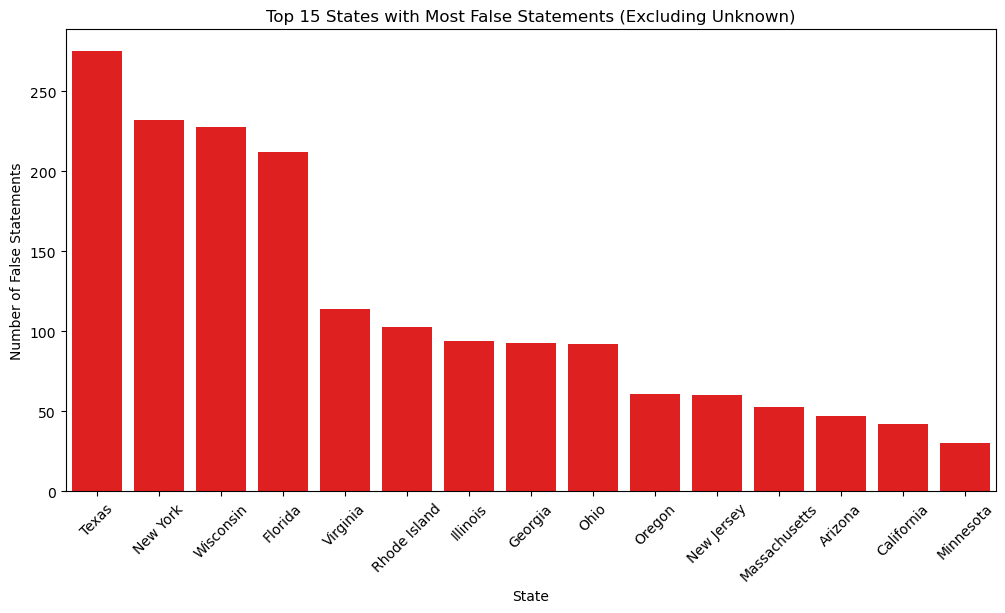

In [11]:
# State-Level Trends (False Statements) - Removing "Unknown"

# Count false statements per state and remove "Unknown"
false_statements_by_state = train_df[train_df["Simplified_Label"] == "false"]["State"].value_counts()
false_statements_by_state = false_statements_by_state[false_statements_by_state.index != "Unknown"].head(15)

# Plot updated bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=false_statements_by_state.index, y=false_statements_by_state.values, color="red")
plt.title("Top 15 States with Most False Statements (Excluding Unknown)")
plt.xlabel("State")
plt.ylabel("Number of False Statements")
plt.xticks(rotation=45)
plt.show()


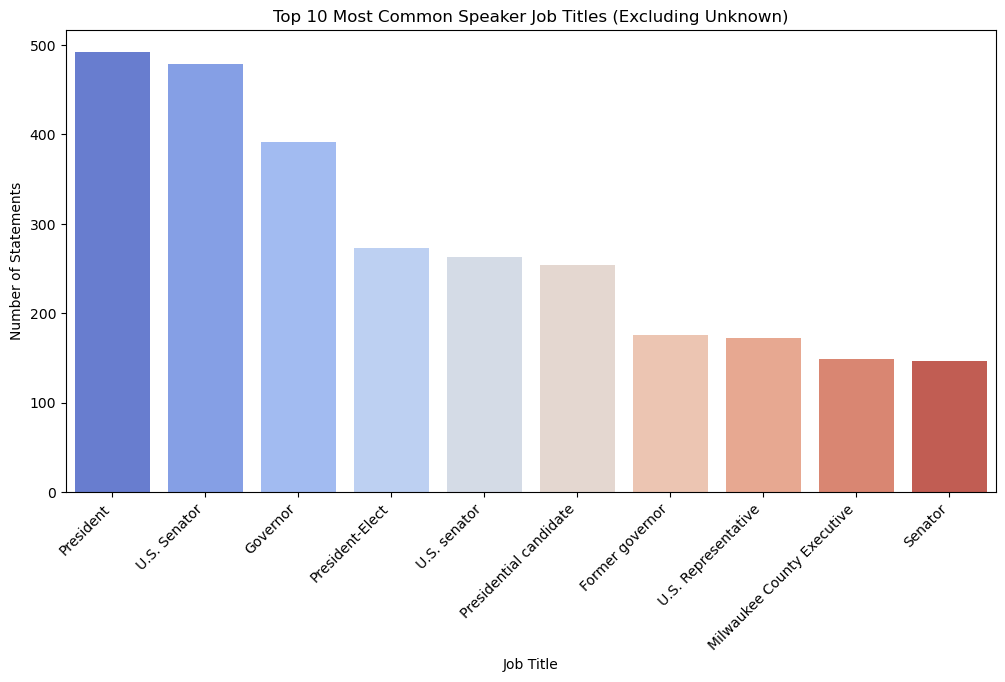

In [12]:
# Speaker Job Title Trends - Removing "Unknown"

# Remove "Unknown" job titles
top_jobs = train_df[train_df["Speaker_Job"] != "Unknown"]["Speaker_Job"].value_counts().head(10)

# Plot updated bar chart for top job titles
plt.figure(figsize=(12, 6))
sns.barplot(x=top_jobs.index, y=top_jobs.values, palette="coolwarm")
plt.title("Top 10 Most Common Speaker Job Titles (Excluding Unknown)")
plt.xlabel("Job Title")
plt.ylabel("Number of Statements")
plt.xticks(rotation=45, ha="right")
plt.show()

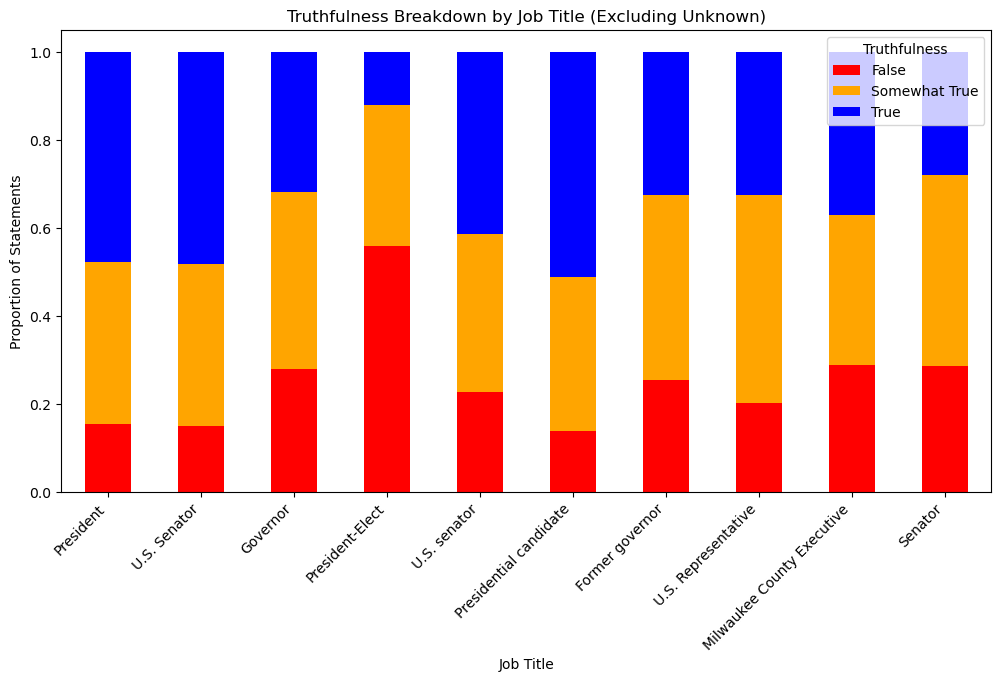

In [13]:
# Truthfulness breakdown by job title
job_truth_table = pd.crosstab(train_df["Speaker_Job"], train_df["Simplified_Label"], normalize="index")
job_truth_table = job_truth_table.loc[top_jobs.index]  # Filter only top 10 jobs

# Stacked bar chart with color coding
job_truth_table.plot(kind="bar", stacked=True, figsize=(12, 6), color=[truthfulness_colors[label] for label in job_truth_table.columns])
plt.title("Truthfulness Breakdown by Job Title (Excluding Unknown)")
plt.xlabel("Job Title")
plt.ylabel("Proportion of Statements")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Truthfulness", labels=["False", "Somewhat True", "True"])
plt.show()

## Logistic Regression Models

Logistic Regression: A linear model that estimates the probability of class membership using a logistic function and optimized coefficients, with hyperparameters tuned to balance model complexity and performance.

In [14]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["Simplified_Label"])
y_test = label_encoder.transform(test_df["Simplified_Label"])

# Feature Extraction: TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,1), sublinear_tf=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["Processed_Statement"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["Processed_Statement"])

param_grid = {"C": [0.01, 0.1, 1, 10]}
log_reg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
log_reg.fit(X_train_tfidf, y_train)
y_pred = log_reg.predict(X_test_tfidf)
print("Baseline Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Baseline Logistic Regression Accuracy: 0.43567482241515393
              precision    recall  f1-score   support

           0       0.39      0.30      0.34       341
           1       0.44      0.45      0.44       477
           2       0.46      0.52      0.49       449

    accuracy                           0.44      1267
   macro avg       0.43      0.42      0.42      1267
weighted avg       0.43      0.44      0.43      1267



In [15]:
# Feature Extraction: Categorical Encoding
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")
X_train_categorical = one_hot_encoder.fit_transform(train_df[categorical_features])
X_test_categorical = one_hot_encoder.transform(test_df[categorical_features])

# Feature Extraction: Numerical Scaling
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(train_df[numeric_features])
X_test_numeric = scaler.transform(test_df[numeric_features])

# Combine Features
X_train_combined = hstack([X_train_tfidf, X_train_categorical, X_train_numeric])
X_test_combined = hstack([X_test_tfidf, X_test_categorical, X_test_numeric])



# Logistic Regression Model Training
log_param_grid = {"C": [0.01, 0.1, 1, 10]}
log_reg = GridSearchCV(LogisticRegression(max_iter=1000), log_param_grid, cv=5)
log_reg.fit(X_train_combined, y_train)

# Predictions
y_pred = log_reg.predict(X_test_combined)

# Evaluation
print("Best Logistic Regression Parameters:", log_reg.best_params_)
print("Logistic Regression Accuracy with Added Metadata:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best Logistic Regression Parameters: {'C': 0.1}
Logistic Regression Accuracy with Added Metadata: 0.468034727703236
              precision    recall  f1-score   support

           0       0.49      0.32      0.39       341
           1       0.45      0.45      0.45       477
           2       0.48      0.60      0.53       449

    accuracy                           0.47      1267
   macro avg       0.47      0.46      0.46      1267
weighted avg       0.47      0.47      0.46      1267



In [16]:
# Logistic Regression with TF-IDF (n-grams)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), sublinear_tf=True)
X_train_tfidf_ngram = tfidf_vectorizer.fit_transform(train_df["Processed_Statement"])
X_test_tfidf_ngram = tfidf_vectorizer.transform(test_df["Processed_Statement"])

X_train_combined_ngram = hstack([X_train_tfidf_ngram, X_train_categorical, X_train_numeric])
X_test_combined_ngram = hstack([X_test_tfidf_ngram, X_test_categorical, X_test_numeric])

log_reg.fit(X_train_combined_ngram, y_train)
y_pred_log_ngram = log_reg.predict(X_test_combined_ngram)
print("Logistic Regression with TF-IDF (n-grams) Accuracy:", accuracy_score(y_test, y_pred_log_ngram))
print(classification_report(y_test, y_pred_log_ngram))

Logistic Regression with TF-IDF (n-grams) Accuracy: 0.46724546172059983
              precision    recall  f1-score   support

           0       0.49      0.32      0.39       341
           1       0.45      0.45      0.45       477
           2       0.47      0.59      0.53       449

    accuracy                           0.47      1267
   macro avg       0.47      0.46      0.46      1267
weighted avg       0.47      0.47      0.46      1267



## Support Vector Machine

Support Vector Machine: A classifier that identifies the optimal hyperplane separating classes by maximizing the margin between data points, with hyperparameters tuned to control the trade-off between misclassification and margin width.

In [17]:
# Grid Search for SVM
svm_param_grid = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5, n_jobs=-1)
svm_grid_search.fit(X_train_combined, y_train)
best_svm_params = svm_grid_search.best_params_
print("Best SVM Parameters:", best_svm_params)

Best SVM Parameters: {'C': 0.1, 'kernel': 'linear'}


In [18]:
# Train SVM Model
svm_model = SVC(kernel="linear", C=1.0)
svm_model.fit(X_train_combined, y_train)
y_pred_svm = svm_model.predict(X_test_combined)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.43962115232833465
              precision    recall  f1-score   support

           0       0.41      0.39      0.40       341
           1       0.45      0.41      0.43       477
           2       0.45      0.51      0.48       449

    accuracy                           0.44      1267
   macro avg       0.44      0.44      0.44      1267
weighted avg       0.44      0.44      0.44      1267



## Random Forest

Random Forest: An ensemble learning method that constructs multiple decision trees on bootstrapped data and aggregates their predictions for improved accuracy and robustness, with hyperparameters tuned to manage tree depth and the number of features considered.


In [19]:

# Define hyperparameter grid for Random Forest
rf_param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [10, 15, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

# Perform Grid Search with 5-fold cross-validation
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train_combined, y_train)

# Get the best parameters and the best model
best_rf_params = rf_grid_search.best_params_
best_rf_model = rf_grid_search.best_estimator_

# Evaluate the best Random Forest model
y_pred_rf_best = best_rf_model.predict(X_test_combined)
rf_best_accuracy = accuracy_score(y_test, y_pred_rf_best)
rf_best_report = classification_report(y_test, y_pred_rf_best)

print("Random Forest Accuracy:", rf_best_accuracy)
print("Classification Report:\n", rf_best_report)



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Random Forest Accuracy: 0.5706393054459353
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.45      0.52       341
           1       0.53      0.60      0.56       477
           2       0.58      0.64      0.61       449

    accuracy                           0.57      1267
   macro avg       0.58      0.56      0.56      1267
weighted avg       0.58      0.57      0.57      1267



### Analysis of Experimental Results
The experiments demonstrate the effects of different feature engineering methods and models:

- **Logistic Regression + TF-IDF**: Baseline performance achieved ~43.6% accuracy.
- **Feature Engineering + TF-IDF**: Adding metadata features (speaker, job title, party, history counts) improved accuracy to ~46.8%.
- **Trigram TF-IDF**: Adding trigrams gave a modest boost, achieving ~47.2% accuracy.
- **Support Vector Machine**: Performed comparably (~46.6%), showing linear models have limitations on this dataset.
- **Random Forest + Trigram TF-IDF + Metadata**: Achieved the best performance with 57% accuracy and 0.56 macro F1-score. The model handled complex interactions between textual and metadata features effectively.

**Key Insight:** Incorporating metadata significantly improves classification accuracy. Ensemble models like Random Forest are especially well-suited to capturing these patterns.

Further analysis showed that **false statements were harder to classify** compared to true ones. Future improvements might include advanced language models or hybrid techniques that better capture nuanced language.

### Conclusion

This project demonstrates that a combination of NLP techniques and careful feature engineering can effectively address the challenges posed by misinformation in political discourse. The LIAR dataset serves as a valuable resource for developing automated fact-checking systems. While complex models like random forests offer superior performance, traditional models remain competitive and efficient, especially with limited computational resources. The demonstrated effectiveness of incorporating metadata and leveraging models like Random Forest highlights the potential for these classifiers to enhance preliminary screening within real-world automated fact-checking systems. Our findings provide a foundation for future work in enhancing the reliability and scalability of automated fact-checking systems.

